In [12]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

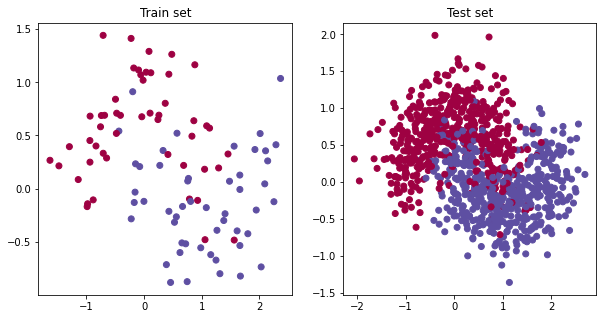

In [2]:
np.random.seed(16)
tr_x, tr_y = make_moons(100, noise=0.3)
ts_x, ts_y = make_moons(1000, noise=0.3)

xx, yy = np.meshgrid(np.arange(-2, 3, 0.05), np.arange(-1.5, 2.0, 0.05))
zz = np.concatenate([xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(tr_x[:,0], tr_x[:,1], c=tr_y, cmap=plt.cm.Spectral)
axs[0].set_title('Train set')
axs[1].scatter(ts_x[:,0], ts_x[:,1], c=ts_y, cmap=plt.cm.Spectral)
axs[1].set_title('Test set')
plt.show()

# Boosting

Boosting has a few forms: Adaptive Boosting and Gradient Boosting. Both forms have in common the idea of training a sequence of models, each which is biased to handle the failed cases of the previous model. Adaptive Boosting (AdaBoost) does this by re-weighting samples for each classifier in series, such that samples which the previous classifiers performed badly on have a higher contribution to the loss.

Gradient boosting instead writes the classification as a linear combination of models and then uses gradient descent to find the fit parameters.

- In principle both types of boosting can be used as a wrapper on pretty much any kind of base model.
- Both types of boosting need to be concerned with the number of classifiers (can be thought of as iterations)
- Both types of boosting have a 'learning rate' parameter, which is how aggressively the weights/coefficients change.
- Gradient Boosting supports directly targetting a loss function (may be different than the function the weak learners are optimizing)

Bagging is good for rounding out overfitting, but Boosting is better suited for fixing underfitting. This is why boosting is usually referred to as using a collection of 'weak learners'

**Note**: Scikit-Learn has a generic Adaptive Boosting wrapper, but it's GradientBoostingClassifier specifically uses only decision trees as the base model. I'm not aware of a simple generic gradient boosting wrapper, though when we get to stacking we'll sort of come back to something related.

In [3]:
def plot_results(clf_1, clf_2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # SVC
    time_now = time.time()
    clf_1.fit(tr_x, tr_y)
    p = clf_1.predict_proba(zz)
    p = p.reshape((xx.shape[0], xx.shape[1], 2))
    cax = axs[0].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
    cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[0])
    axs[0].scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
    axs[0].set_title(f'Accuracy: {clf_1.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec')

    # Bagging SVC
    time_now = time.time()
    clf_2.fit(tr_x, tr_y)
    p = clf_2.predict_proba(zz)
    p = p.reshape((xx.shape[0], xx.shape[1], 2))
    cax = axs[1].contourf(xx, yy, p[:,:,1], alpha=0.5, cmap=plt.cm.Spectral)
    cbar = plt.colorbar(cax, ticks=[-1, 0, 1], ax=axs[1])
    axs[1].scatter(tr_x[:,0], tr_x[:,1], c=tr_y, cmap=plt.cm.Spectral)
    axs[1].set_title(f'Accuracy: {clf_2.score(ts_x, ts_y)}, time: {(time.time() - time_now):.2f} sec')

    plt.tight_layout()

In [4]:
# Bagging helps us recover from the overfit at 5x the cost

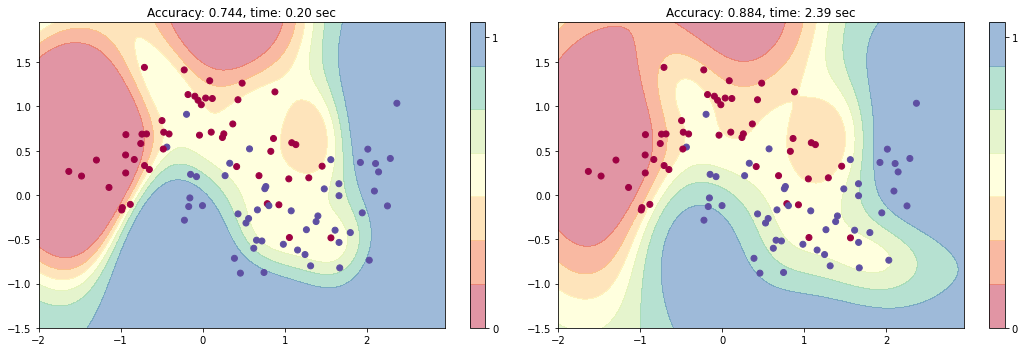

In [8]:
clf_1 = SVC(C=100000, gamma='scale', probability=True)
clf_2 = AdaBoostClassifier(SVC(C=100000, gamma='scale', probability=True), n_estimators = 50, learning_rate = 0.1)
plot_results(clf_1, clf_2)

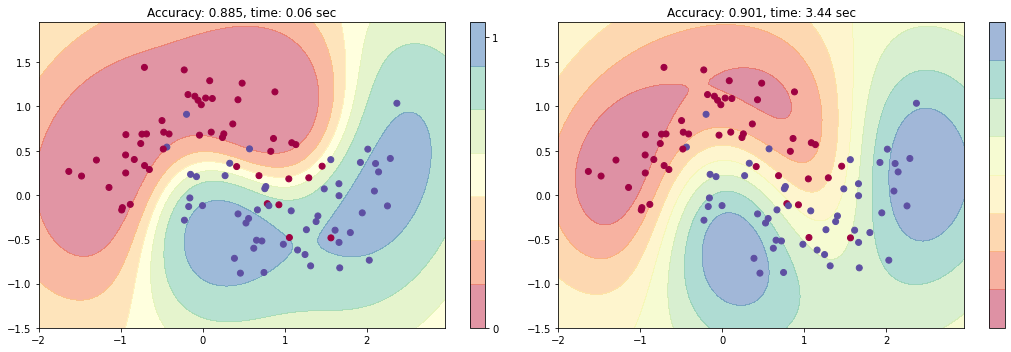

In [9]:
clf_1 = SVC(C=1, gamma='scale', probability=True)
clf_2 = AdaBoostClassifier(SVC(C=1, gamma='scale', probability=True), n_estimators = 50, learning_rate = 0.1)
plot_results(clf_1, clf_2)

Adaboost, SVC - underfit case
When boosting an underfitting classifier, the result can be better

Note - we needed to increase n_estimators above the default, and drop the learning rate to
get this result. Otherwise, it would converge too aggressively to fix the underfit.

So you do need to tune those hyperparameters!

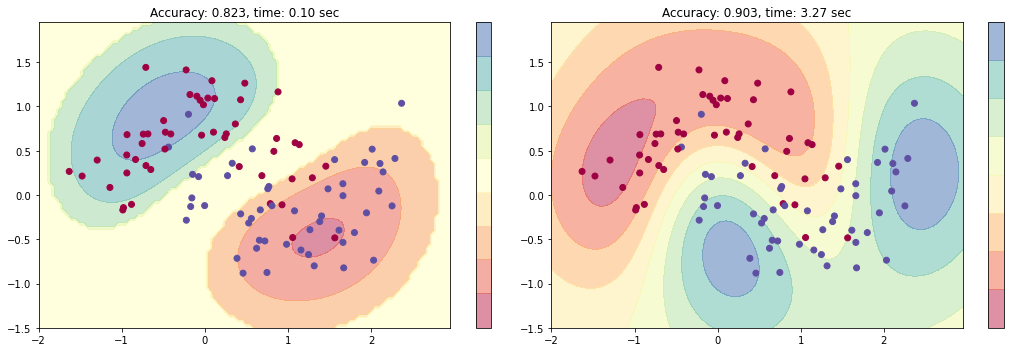

In [10]:
# An underfitting classifier...
clf_1 = SVC(C=0.01, gamma='scale', probability=True)
clf_2 = AdaBoostClassifier(SVC(C=0.01, gamma='scale', probability=True), n_estimators = 50, learning_rate = 0.1)
plot_results(clf_1, clf_2)

### Decision trees

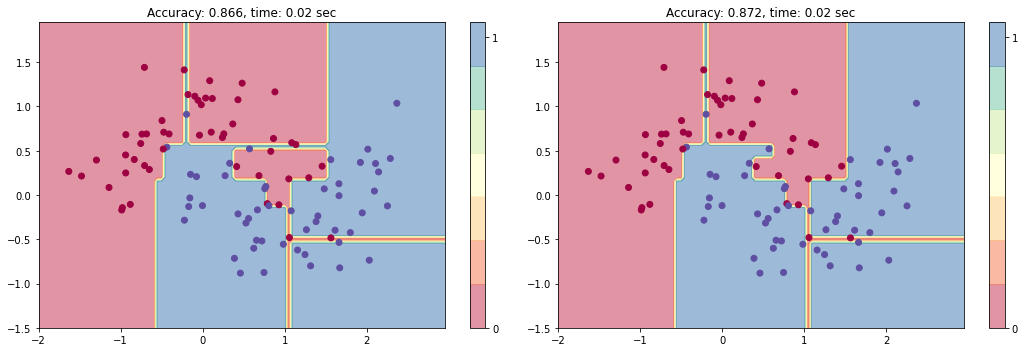

In [17]:
clf_1 = DecisionTreeClassifier()
clf_2 = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, learning_rate = 0.1)
plot_results(clf_1, clf_2)

### Linear models

Boosting still won't save a linear model...

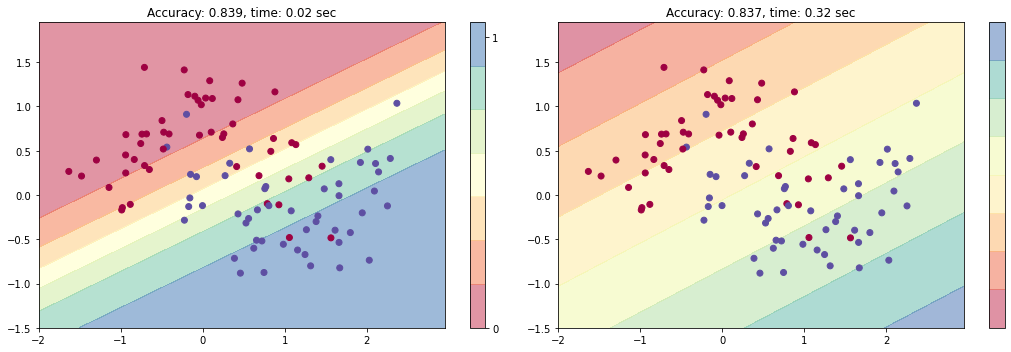

In [15]:
clf_1 = LogisticRegression(C=10000, solver='lbfgs')
clf_2 = AdaBoostClassifier(LogisticRegression(C=10000, solver='lbfgs'), n_estimators=100, learning_rate = 0.1)
plot_results(clf_1, clf_2)

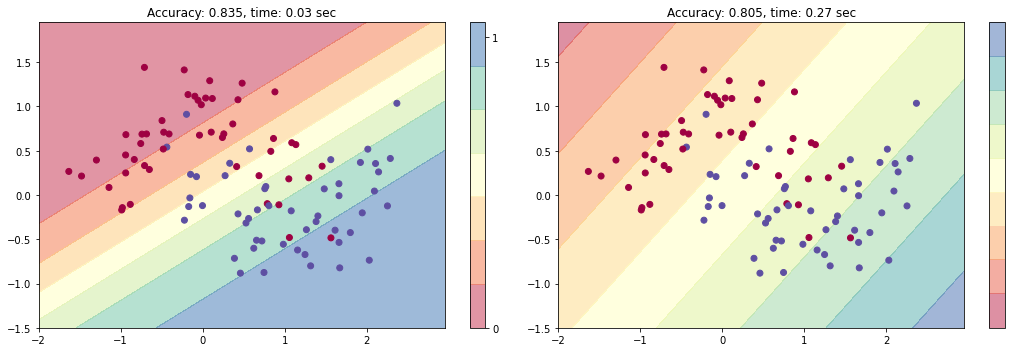

In [16]:
clf_1 = LogisticRegression()
clf_2 = AdaBoostClassifier(LogisticRegression(), n_estimators=100, learning_rate = 0.1)
plot_results(clf_1, clf_2)

### Boosting as a general wrapper

If we want to use AdaBoost with a custom model, the `fit` method has to support the `sample_weight` argument.
(Again though, it works better with weaker base models - the neural network is probably a bit much here).

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(2, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 64)
        self.l4 = nn.Linear(64, 2)
        self.optim = torch.optim.Adam(self.parameters(), lr=1e-2)
    
    def forward(self, x):
        z = F.leaky_relu(self.l1(x))
        z = F.leaky_relu(self.l2(z))
        z = F.leaky_relu(self.l3(z))
        z = F.log_softmax(self.l4(z),1)
        return z

class NetworkClassifier(BaseEstimator):
    def __init__(self):
        super().__init__()
        self.classes_ = np.array([0, 1])
        self.net = Net()
                
    def get_params(self, deep=True):        
        return {}

    def set_params(self, **parameters):
        return self
    
    def fit(self, x, y, sample_weight = None):
        self.net = Net()        
        idx = torch.arange(x.shape[0]).long()
        yy = torch.LongTensor(y)
        
        if sample_weight is not None:  # Useful for the AdaBoost
            w = torch.FloatTensor(sample_weight)
        else:
            w = torch.ones(x.shape[0])
            
        for i in range(150):
            self.net.optim.zero_grad()
            p = self.net.forward(torch.FloatTensor(x))
            loss = -torch.mean(w * p[idx, yy[idx]])
            loss.backward()
            self.net.optim.step()
    
    def predict_proba(self, x):
        p = np.exp(self.net.forward(torch.FloatTensor(x)).cpu().detach().numpy())
        return p
    
    def score(self, x, y):
        p = self.predict_proba(x)
        p = np.argmax(p,axis=1)
        
        return np.mean(p==y)

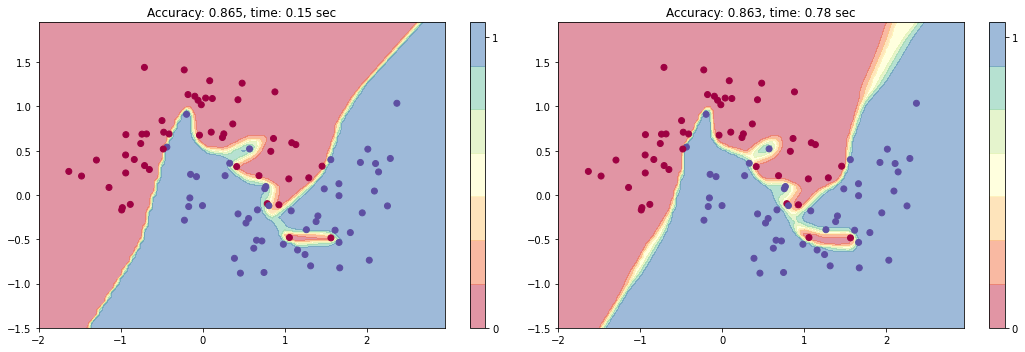

In [20]:
clf_1 = NetworkClassifier()
clf_2 = AdaBoostClassifier(NetworkClassifier(), n_estimators=100, learning_rate = 0.1)
plot_results(clf_1, clf_2)